# <br> HDBSCAN Clustering analysis performed for hotels' data coming from Bidroom DB + FADM
### Information about data set:<br>
#### 1. Analysis was performed for sample about 1000 data from database. 
#### 2. Data were taken for two cities with the higest number of active hotels. <br> 


In [96]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [97]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn import metrics
import umap
import hdbscan
##libraries needed for clustering analysis
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean, cityblock
from DBCV.DBCV import DBCV

pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', True)


## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [98]:
file = pd.read_csv("../Documents/clustering/dbscan/idGBdata.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   room_type_en         188 non-null    object 
 10  room_type_no         238 non-null    float64
 11  label                0 non-null      float64
 12  amenity              1038 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 105.8+ KB


#### <br> This analysis is provided for characteristics without the room_types that is why I am removing from original file thwo columns: room_type_no and room_type_en  <br>

In [99]:
fileWorking = fileWorking.drop(columns=["room_type_no","room_type_en"])

### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### This analysis is a first of such type for the data we are storing in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [100]:
fileWorking.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,label,amenity
0,5622,1174,4,GB,GBP,51.521259,-0.155856,3.12,34,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
1,5630,1174,3,GB,GBP,51.512071,-0.185206,4.30,45,NaN,"Free WIFI,Elevator / Lift,Free WIFI,Elevator /..."
2,5640,1174,4,GB,GBP,51.507706,-0.147138,1.67,106,NaN,"Free WIFI,Elevator / Lift,Parking,Fitness Room..."
3,5671,1174,4,GB,GBP,51.490098,-0.138130,1.39,72,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
4,5681,1174,5,GB,GBP,51.496872,-0.167604,2.89,28,NaN,"Free WIFI,Elevator / Lift,Parking,Pet Friendly..."


In [101]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   label                0 non-null      float64
 10  amenity              1038 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 89.5+ KB


In [102]:
def hotel_type_to_columns(df):
    import category_encoders as ce
    hotel_type_dict = {
        1:2,
        2:2,
        3:3,
        4:4,
        5:5,
        8:4, 
        9:3,
        10:3,
        11:3,
        12:3,
        13:4,
        15:4,
        16:1, 
        23:4,
        25:5,
        30:3,
        32:2,
        33:5,
        34:3,
        36:3
    }   
    df["hotel_type_ordinary"] = df.hotel_type.map(hotel_type_dict)
    df.columns = df.columns.str.lower()
    df = df.drop(columns=["hotel_type"])
    return df
fileWorking = hotel_type_to_columns(fileWorking)

### Creating separate sets of amenities for each city

#### Creating working file for Jakarta in Indonesia

In [103]:
fileWorkingID = fileWorking.loc[fileWorking.hotel_country=="ID"]
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 17 to 995
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             648 non-null    int64  
 1   hotel_city           648 non-null    int64  
 2   hotel_country        648 non-null    object 
 3   hotel_currency_code  648 non-null    object 
 4   hotel_lat            648 non-null    float64
 5   hotel_lon            648 non-null    float64
 6   hotel_distance       636 non-null    float64
 7   rooms_count          648 non-null    int64  
 8   label                0 non-null      float64
 9   amenity              648 non-null    object 
 10  hotel_type_ordinary  648 non-null    int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 60.8+ KB


#### Creating working file for London in Great Britain

In [104]:
fileWorkingGB = fileWorking.loc[fileWorking.hotel_country=="GB"]
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 1039
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             392 non-null    int64  
 1   hotel_city           392 non-null    int64  
 2   hotel_country        392 non-null    object 
 3   hotel_currency_code  392 non-null    object 
 4   hotel_lat            392 non-null    float64
 5   hotel_lon            392 non-null    float64
 6   hotel_distance       245 non-null    float64
 7   rooms_count          392 non-null    int64  
 8   label                0 non-null      float64
 9   amenity              390 non-null    object 
 10  hotel_type_ordinary  392 non-null    int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 36.8+ KB


In [105]:
def handleAmenities(df):
    import re
    amenities =  []
    for num, x in enumerate(df["amenity"]):
        try:
            x = x.split(sep=',')
            amenities = amenities + x
        except:
            amenities.append(x)
    amenities = list(set(amenities))
    for x in amenities:
        if x != x:
            continue
        else:
            com = '(.*)?('+ x +')(.*)?'
            df[x]=[1 if re.search(com,str(a)) is not None else 0 for a in df["amenity"]]
    df = df.drop(columns=["amenity"])
    return df

amenitiesID = handleAmenities(fileWorkingID[["hotel_id","amenity"]])
amenitiesGB = handleAmenities(fileWorkingGB[["hotel_id","amenity"]])

<ipython-input-105-b7a18e951cdb>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Creating final dataset for clustering analysis

In [106]:
# for Jakarta
fileWorkingID = fileWorkingID.merge(amenitiesID, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingID.columns = fileWorkingID.columns.str.lower()

# for London
fileWorkingGB = fileWorkingGB.merge(amenitiesGB, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingGB.columns = fileWorkingGB.columns.str.lower()

In [107]:
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               648 non-null    int64  
 1   hotel_city             648 non-null    int64  
 2   hotel_country          648 non-null    object 
 3   hotel_currency_code    648 non-null    object 
 4   hotel_lat              648 non-null    float64
 5   hotel_lon              648 non-null    float64
 6   hotel_distance         636 non-null    float64
 7   rooms_count            648 non-null    int64  
 8   label                  0 non-null      float64
 9   hotel_type_ordinary    648 non-null    int64  
 10  parking                648 non-null    int64  
 11  fitness room/gym       648 non-null    int64  
 12  business centre        648 non-null    int64  
 13  disabled access        648 non-null    int64  
 14  spa & wellness centre  648 non-null    int64  
 15  swimmi

## Data Cleaning

### Removing duplicates

In [108]:
# for Jakarta
filesWorkingIDCleaned = fileWorkingID.drop_duplicates(subset=["hotel_id"], keep="first")
# for London
filesWorkingGBCleaned = fileWorkingGB.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

#### handling information for hotel_distance 

In [109]:
filesWorkingIDCleaned["hotel_distance"].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
643     True
644     True
645     True
646     True
647     True
Name: hotel_distance, Length: 648, dtype: bool

In [110]:
filesWorkingIDCleaned["hotel_distance"].value_counts(dropna=False)

3.90     20
4.15     14
10.84    14
NaN      12
13.62     7
         ..
4.39      1
6.12      1
8.38      1
7.39      1
10.75     1
Name: hotel_distance, Length: 383, dtype: int64

In [111]:
filesWorkingGBCleaned["hotel_distance"].value_counts(dropna=False)

NaN     147
3.84      4
2.96      3
4.46      3
2.39      3
       ... 
2.67      1
7.13      1
4.53      1
1.04      1
8.00      1
Name: hotel_distance, Length: 203, dtype: int64

#### There is lack of calculated hotel distance for 147 hotels in London and 12 for Jakarta so I used mean calculated per city o fill that data

In [112]:
mean1  = filesWorkingIDCleaned["hotel_distance"].mean()
mean2  = filesWorkingGBCleaned["hotel_distance"].mean()
filesWorkingIDCleaned["hotel_distance"].fillna(mean2, inplace=True)
filesWorkingGBCleaned["hotel_distance"].fillna(mean1, inplace=True)

In [113]:
filesWorkingIDCleaned["hotel_distance"].isna().value_counts()

False    648
Name: hotel_distance, dtype: int64

In [114]:
filesWorkingIDCleaned["hotel_lat"].isna().value_counts()

False    648
Name: hotel_lat, dtype: int64

In [115]:
filesWorkingIDCleaned["hotel_lon"].isna().value_counts()

False    648
Name: hotel_lon, dtype: int64

In [116]:
filesWorkingIDCleaned["rooms_count"].isna().value_counts()

False    648
Name: rooms_count, dtype: int64

#### dropping columns that have only one value and it is 0 

In [117]:
filesWorkingIDCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               648 non-null    int64  
 1   hotel_city             648 non-null    int64  
 2   hotel_country          648 non-null    object 
 3   hotel_currency_code    648 non-null    object 
 4   hotel_lat              648 non-null    float64
 5   hotel_lon              648 non-null    float64
 6   hotel_distance         648 non-null    float64
 7   rooms_count            648 non-null    int64  
 8   label                  0 non-null      float64
 9   hotel_type_ordinary    648 non-null    int64  
 10  parking                648 non-null    int64  
 11  fitness room/gym       648 non-null    int64  
 12  business centre        648 non-null    int64  
 13  disabled access        648 non-null    int64  
 14  spa & wellness centre  648 non-null    int64  
 15  swimmi

In [118]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["label", "hotel_city", "hotel_country"])
filesWorkingGBCleaned = filesWorkingGBCleaned.drop(columns=["label","hotel_city","hotel_country"])

In [119]:
filesWorkingIDCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               648 non-null    int64  
 1   hotel_currency_code    648 non-null    object 
 2   hotel_lat              648 non-null    float64
 3   hotel_lon              648 non-null    float64
 4   hotel_distance         648 non-null    float64
 5   rooms_count            648 non-null    int64  
 6   hotel_type_ordinary    648 non-null    int64  
 7   parking                648 non-null    int64  
 8   fitness room/gym       648 non-null    int64  
 9   business centre        648 non-null    int64  
 10  disabled access        648 non-null    int64  
 11  spa & wellness centre  648 non-null    int64  
 12  swimming pool          648 non-null    int64  
 13  air conditioned        648 non-null    int64  
 14  elevator / lift        648 non-null    int64  
 15  free w

## Data Reduction

#### calc_vif - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was higher than 5.¶
#### reduce_dimensions_by_pca -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables.

In [120]:
def calc_vif(df):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[(vif["VIF"].isnull())]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    if "const" in col_names:       
        const_to_remove = col_names.index("const")
        del col_names[const_to_remove]

    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

In [121]:
filesWorkingIDCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               648 non-null    int64  
 1   hotel_currency_code    648 non-null    object 
 2   hotel_lat              648 non-null    float64
 3   hotel_lon              648 non-null    float64
 4   hotel_distance         648 non-null    float64
 5   rooms_count            648 non-null    int64  
 6   hotel_type_ordinary    648 non-null    int64  
 7   parking                648 non-null    int64  
 8   fitness room/gym       648 non-null    int64  
 9   business centre        648 non-null    int64  
 10  disabled access        648 non-null    int64  
 11  spa & wellness centre  648 non-null    int64  
 12  swimming pool          648 non-null    int64  
 13  air conditioned        648 non-null    int64  
 14  elevator / lift        648 non-null    int64  
 15  free w

In [122]:
filesWorkingGBCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    392 non-null    int64  
 1   hotel_currency_code         392 non-null    object 
 2   hotel_lat                   392 non-null    float64
 3   hotel_lon                   392 non-null    float64
 4   hotel_distance              392 non-null    float64
 5   rooms_count                 392 non-null    int64  
 6   hotel_type_ordinary         392 non-null    int64  
 7   lounge area                 392 non-null    int64  
 8   conference facilities       392 non-null    int64  
 9   room turnaround service     392 non-null    int64  
 10  rooftop bar                 392 non-null    int64  
 11  fine dining restaurant      392 non-null    int64  
 12  spa & wellness centre       392 non-null    int64  
 13  projector                   392 non

In [123]:
indonesia = filesWorkingIDCleaned.drop(columns=["hotel_id", "hotel_currency_code"])
gb = filesWorkingGBCleaned.drop(columns=["hotel_id", "hotel_currency_code"])

In [124]:
gbToReduce = calc_vif(gb)
idToReduce = calc_vif(indonesia)

/home/agata/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



In [125]:
idReduced = select_variables(filesWorkingIDCleaned, idToReduce)
gbReduced = select_variables(filesWorkingGBCleaned, gbToReduce)

#### Creating copy that is not containing Hotel id for the analysis

In [126]:
idReducedAnalysis = idReduced.drop(columns=["hotel_id"])
gbReducedAnalysis = gbReduced.drop(columns=["hotel_id"])

In [127]:
#### ploting correlation heatmap for final hotel characteristics

(648, 15)

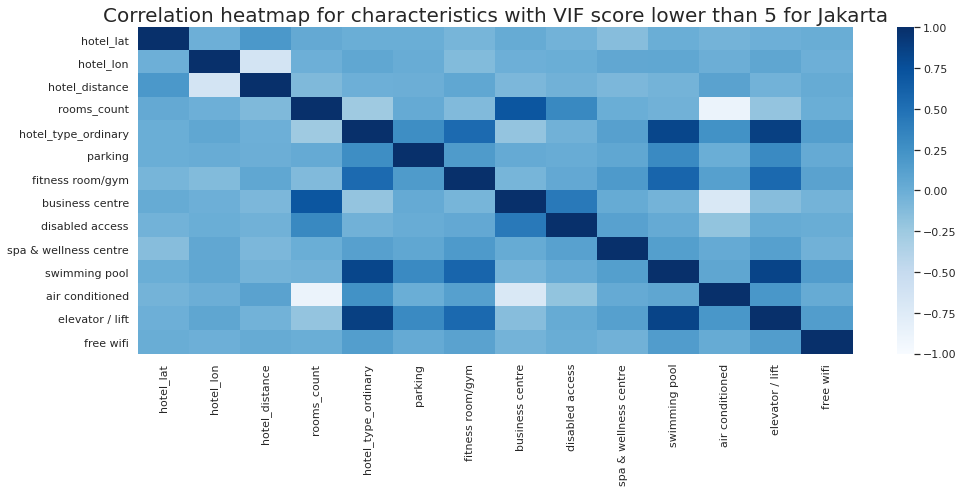

In [128]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(idReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for Jakarta", fontsize=20)
idReducedAnalysis.shape

(392, 15)

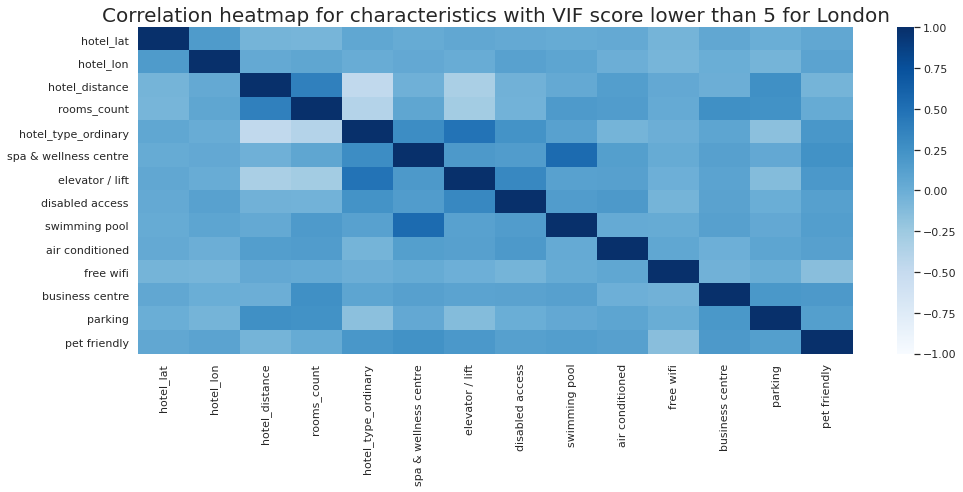

In [129]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gbReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for London", fontsize=20)
gbReducedAnalysis.shape

### Conclusions


## <br> Removing Dimentions with famd algorythm

####  <br> This time I used FAMD to reduce dimentionality of the provided data. FAMD is more recomended by some data scientists/publications for such analysis which have mixed types of data that is why I wanted to check if for our purposes it will reduce the dimentionality of data saving the most important information to generate better estimations of clusters later.  <br>

#### FAMD for Jakarta

In [130]:
import prince

famd = prince.FAMD(
n_components=3,
n_iter=3,
copy=True,
check_input=True,
engine='auto',
random_state=42
)
famd = famd.fit(idReducedAnalysis)

In [131]:
reducedID = famd.row_coordinates(idReducedAnalysis)
reducedID.values

reducedID_df = pd.DataFrame(data=np.c_[reducedID.values], columns=['famd1','famd2','famd3'])

No handles with labels found to put in legend.


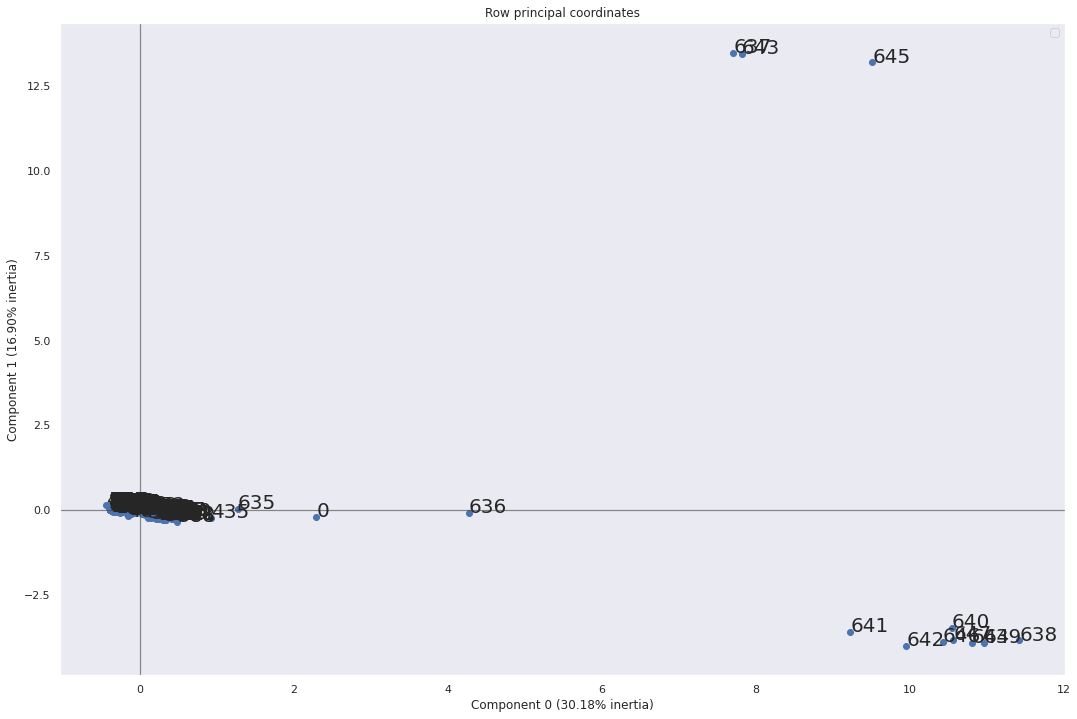

In [132]:
ax = famd.plot_row_coordinates(
idReducedAnalysis,
ax=None,
figsize=(18, 12),
x_component=0,
y_component=1,
labels=idReducedAnalysis.index,
ellipse_outline=False,
ellipse_fill=True,
show_points=True,
)

#### FAMD for London

In [133]:
famd = prince.FAMD(
n_components=3,
n_iter=3,
copy=True,
check_input=True,
engine='auto',
random_state=42
)
famd = famd.fit(gbReducedAnalysis)

In [134]:
reducedGB = famd.row_coordinates(gbReducedAnalysis)
reducedGB.values

reducedGB_df = pd.DataFrame(data=np.c_[reducedGB.values], columns=['famd1','famd2', 'famd3'])
reducedGB_df 

,famd1,famd2,famd3
0,-0.953438,0.132347,-0.136061
1,-0.511375,-0.242973,0.303924
2,-0.148312,0.904100,-1.009927
3,-0.984772,0.165154,-0.170330
4,-0.464005,1.132664,-1.203998
...,...,...,...
387,3.776382,-0.105221,-0.002388
388,-0.418749,0.997643,-1.111239
389,-0.176019,-0.040981,0.158702
390,-0.841634,0.110327,-0.367313


In [135]:
reducedGB.values

array([[-0.9534384 ,  0.13234722, -0.13606102],
       [-0.51137516, -0.24297307,  0.30392429],
       [-0.14831176,  0.90410012, -1.00992652],
       ...,
       [-0.1760186 , -0.04098092,  0.15870194],
       [-0.84163388,  0.11032703, -0.36731266],
       [-0.35309746, -0.22776771,  0.21022996]])

No handles with labels found to put in legend.


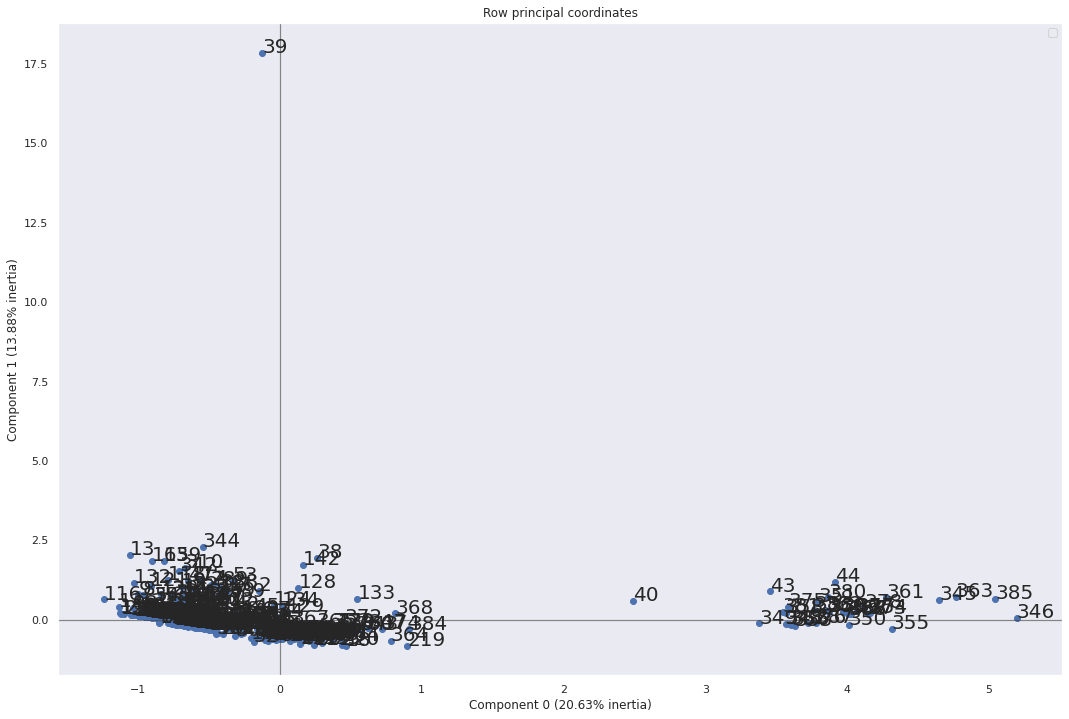

In [136]:
ax = famd.plot_row_coordinates(
gbReducedAnalysis,
ax=None,
figsize=(18, 12),
x_component=0,
y_component=1,
labels=idReducedAnalysis.index,
ellipse_outline=False,
ellipse_fill=True,
show_points=True,
)

## <br> HDBSCAN Clustering analysis<br>

## <br>There were performed 2 analysis:
#### 1. for Jakarta
#### 2. for London<br>

### <br> 1. Jakarta <br>
#### min_cluster_size was found checking different value and taking into consideration these values that have the greatest **DBCV - Denstity Based Clustering Validation** <br>

In [137]:
reducedID_df.iloc[112]

famd1   -0.347936
famd2    0.070639
famd3   -0.573888
Name: 112, dtype: float64

/home/agata/anaconda3/lib/python3.8/site-packages/hdbscan/plots.py:383: UserWarning:

Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.



array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

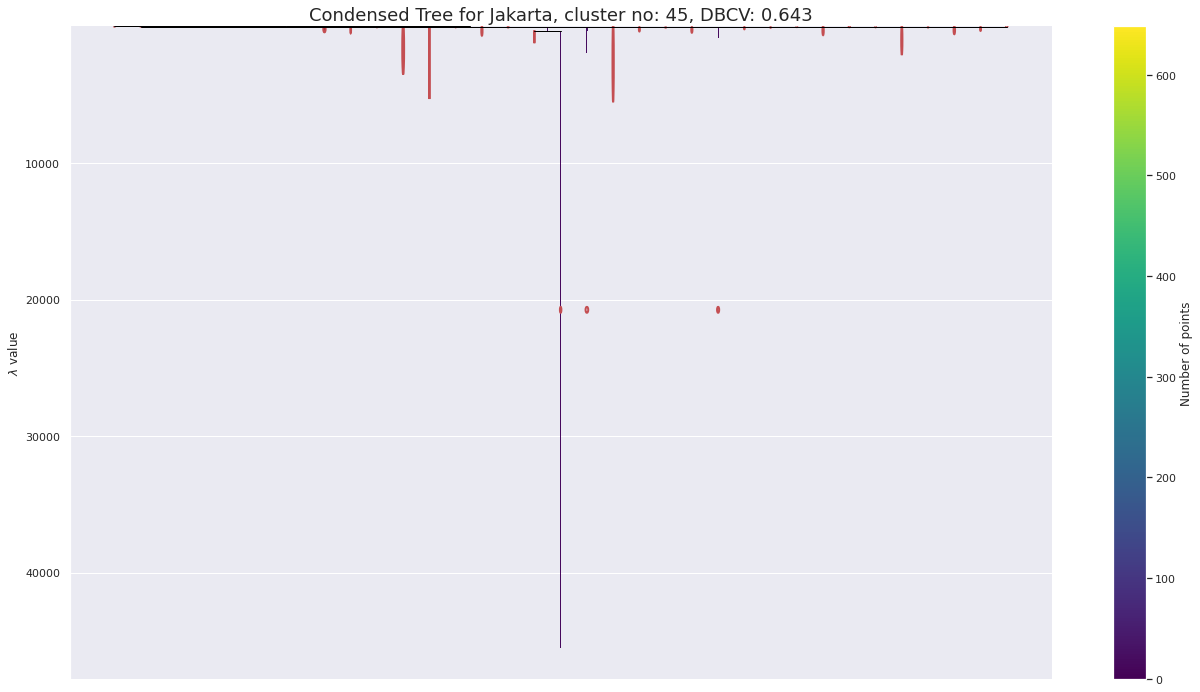

In [138]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for Jakarta, cluster no: 45, DBCV: 0.643", fontdict={"fontsize":18})
hdbscan_indo = hdbscan.HDBSCAN(min_cluster_size=6, metric='manhattan')
labels = hdbscan_indo.fit_predict(reducedID.values)
hdbscan_indo.condensed_tree_.plot(select_clusters=True)
np.unique(labels)


### <br> Summary of general statistics for Jakarta clusters <br>
#### To assess the quality of produced clusters there a few metrics that can be used. Below I calculate the total number of clusters and total number of noice¶
#### which in other words mean that number of points that where not attached to any cluster. <br>

In [139]:
n_clusters_ = len(set(labels[:])) - (1 if -1 in labels[:] else 0)
n_noise_ = list(labels[:]).count(-1)

#### <br>**DBCV - Density Based Clustering Validation** computes two values:

####   - the density within a cluster
####   - the density between clusters
#### High density within a cluster, and low density between clusters indicates good clustering assignments.<br>



In [140]:
reducedID.iloc[640]

0    10.550873
1    -3.483634
2    -2.024992
Name: 640, dtype: float64

In [141]:
labels

array([-1, 10, 30, 12, 21,  1, 18, 27, 17,  2, 30, 25, 27, -1, 10, -1, 27,
       15, 22, 10, -1, 18, 23, 24, 17, 16, -1, 17, 17, 10, -1, 10, -1, 20,
       14, 28, 17, 19, 22,  6, 10, 27,  2, -1, 17, 25, 22,  7,  1, -1, -1,
       -1, 21, 27, 23, 20, -1, 30,  2, 11, -1, 28, 26, 24, 25, 22, 20, 19,
       22,  6, 22, 25, 20, 11, -1, 22,  7,  2, 22,  7,  2, -1, -1,  2,  7,
        7, -1, 12, 16, 20, 28,  8, 17, 26,  8, 27,  7, 11, 23, 24, 17, 13,
        7, 11, 20, 17, 15, 17, 12, 19, 22, 19, 12, 11, 15, 23, -1, -1, 17,
       19, 18, -1, 27, 24, 23, 10, 17,  1, -1, 18, 21, 11,  6, -1,  6, 13,
       17, 23, -1, 11, 15,  2, 11, 11,  6, -1, 10, 24, 19, 29, 26, 15,  7,
       10, 21, 11, 24, 11, -1, 11, 11, 15, -1, 19, 23, 23, 28, 11, 11, 12,
        8, -1, 24, -1, 27, 11, 16, 16, 17, 21,  1, 23, -1,  1, 23, 22, 11,
       -1, 11, 10,  2,  2,  1, 11, 11, 23, 29, 11,  2, -1, -1, 11, 17, 13,
        8,  6, 21, -1, 20, 26, -1, 20, 21, 25, 11, 22, -1, -1, -1, 11, 27,
       -1,  7,  6, 17, 24

### This time to estimate the lenght between two points I used different distance calculation: Manhattan not the Euclidean which was used in previous analysis. I have done this way because this distance generated slightly better estomations of DBCV values for both cities.

In [142]:
hdbscan_score = DBCV(reducedID.values, labels, dist_function=cityblock)

In [143]:
hdbscan_score

0.11036001746234247

In [144]:
print("SUMMARY FOR JAKARTA")
print()
print("Estimation: number of clusters: %d" % n_clusters_)
print("Estimation: number of noise points: %d" % n_noise_)
print("Estimation: DBCV: %0.3f" % hdbscan_score)
print()

SUMMARY FOR JAKARTA

Estimation: number of clusters: 31
Estimation: number of noise points: 121
Estimation: DBCV: 0.110



In [145]:
reducedID_df["cluster"] = labels
idReducedAnalysis["cluster"] = labels

In [146]:
idReducedAnalysis

,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,hotel_type_ordinary,parking,fitness room/gym,business centre,disabled access,spa & wellness centre,swimming pool,air conditioned,elevator / lift,free wifi,cluster
0,IDR,-6.255336,106.810825,6.18000,203,4,1,1,1,1,1,1,1,1,1,-1
1,IDR,-6.175420,106.729023,13.45000,1,4,1,1,0,0,0,1,1,1,1,10
2,IDR,-6.208347,106.818008,3.02000,1,4,1,0,0,0,0,1,1,1,1,30
3,IDR,-6.223455,106.784432,6.84000,1,4,1,1,0,0,0,1,1,1,1,12
4,IDR,-6.162375,106.832172,5.65000,1,4,1,0,0,0,0,1,1,1,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,USD,-6.221410,106.815778,3.92302,214,3,1,0,0,0,0,1,0,0,1,-1
644,EUR,-6.127151,106.790440,3.92302,300,3,1,0,1,0,0,0,0,0,1,0
645,USD,-6.264619,106.782179,3.92302,311,3,1,0,1,0,0,1,0,0,1,-1
646,EUR,-6.187198,106.821936,3.92302,222,3,1,0,1,0,0,0,0,0,1,0


In [147]:
reducedID_df

,famd1,famd2,famd3,cluster
0,2.295306,-0.207736,-2.311967,-1
1,-0.374582,0.041853,-0.492463,10
2,-0.217001,0.028902,-0.220914,30
3,-0.347936,0.070639,-0.573888,12
4,-0.222969,-0.010194,-0.206984,21
...,...,...,...,...
643,7.817888,13.444574,0.464473,-1
644,10.808879,-3.925164,-1.539034,0
645,9.518845,13.195286,-0.115105,-1
646,10.436239,-3.900421,-1.452547,0


In [148]:
px.scatter_3d(reducedID_df, x='famd1', y='famd2', z='famd3', color='cluster', opacity=0.5, width=950,height=700,template='plotly_dark', title='FAMD - 3 components')

### 2. London

array([-1,  0,  1,  2,  3,  4])

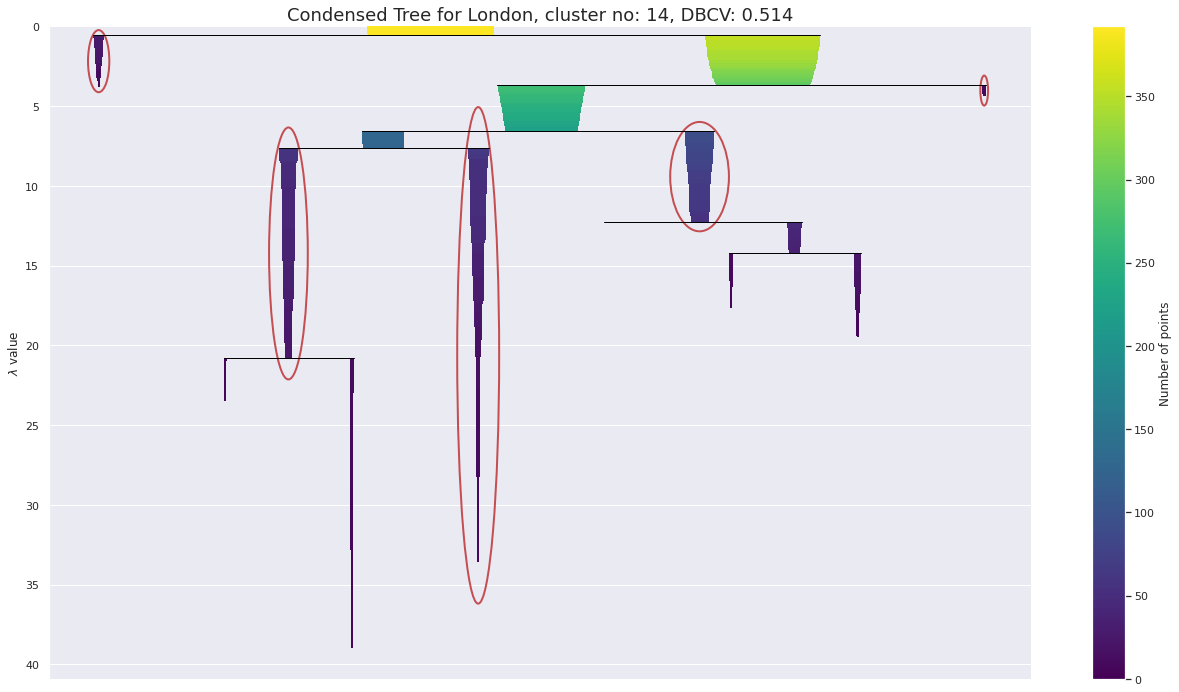

In [149]:
plt.figure(figsize=(22, 12))
plt.title("Condensed Tree for London, cluster no: 14, DBCV: 0.514", fontdict={"fontsize":18})
hdbscan_londo = hdbscan.HDBSCAN(min_cluster_size=6)
labels = hdbscan_londo.fit_predict(reducedGB.values)
hdbscan_londo.condensed_tree_.plot(select_clusters=True)
np.unique(labels)

### <br> Summary of general statistics for London clusters <br>

In [150]:
n_clusters_ = len(set(labels[:])) - (1 if -1 in labels[:] else 0)
n_noise_ = list(labels[:]).count(-1)

In [151]:
hdbscan_score = DBCV(reducedGB.values, labels, dist_function=cityblock)

In [152]:
print("SUMARY FOR LONDON")
print()
print("Estimation: number of clusters: %d" % n_clusters_)
print("Estimation: number of noise points: %d" % n_noise_)
print("Estimation: DBCV: %0.3f" % hdbscan_score)
print()

SUMARY FOR LONDON

Estimation: number of clusters: 5
Estimation: number of noise points: 131
Estimation: DBCV: -0.423



In [153]:
reducedGB_df["cluster"] = labels
gbReducedAnalysis["cluster"] = labels

In [154]:
gbReducedAnalysis

,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,hotel_type_ordinary,spa & wellness centre,elevator / lift,disabled access,swimming pool,air conditioned,free wifi,business centre,parking,pet friendly,cluster
0,GBP,51.521259,-0.155856,3.120000,34,4,0,1,0,0,1,1,0,0,0,3
1,GBP,51.512071,-0.185206,4.300000,45,3,0,1,0,0,0,1,0,0,0,4
2,GBP,51.507706,-0.147138,1.670000,106,4,0,1,0,0,0,1,1,1,1,-1
3,GBP,51.490098,-0.138130,1.390000,72,4,0,1,0,0,1,1,0,0,0,3
4,GBP,51.496872,-0.167604,2.890000,28,5,0,1,0,0,0,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,EUR,51.508232,0.043758,6.915566,225,3,0,0,0,0,0,1,0,1,0,0
388,GBP,51.516015,-0.118570,1.840000,0,4,0,1,0,0,1,1,1,1,1,-1
389,GBP,51.543948,-0.152331,5.200000,1,3,0,0,0,0,0,1,0,0,1,-1
390,GBP,51.511208,-0.119345,1.320000,0,4,0,0,1,0,0,1,0,0,0,-1


In [155]:
px.scatter_3d(reducedGB_df, x='famd1', y='famd2', z='famd3', color='cluster', opacity=0.5, width=1150,height=800,template='plotly_dark', title='FAMD - 3 components')

## <br> Concusions:<br>
#### 1. HDBSCAN analysis for these 2 types of datasets with FAMD algorythm as a dimention reduction algorythm created 31 clusters for Jakarta where different hotel types were 12, 5 for London where different hotel types were 18;
#### 2. DBCV for both cities were around 0 in case of Jakarta it was the above the 0 and in case of London it was below. Small number of clusters for London and DBCV around zero what indicates that clusters are more random than generated on the basis of patterns in data. This analysis is not valid to be compare with the previous ones.
#### 3. It would be worth to check combination of HDBSCAN and FAMD for different distance than euclidean and manhattan which was used in that analysis. I used in this analysis Manhattan over Eucliedian distance to estimate the lenght between two points because it generated slightly better DBCV values. <br>

In [156]:
with pd.ExcelWriter("../Downloads/hdbscanFAMDsamples.xlsx") as writer:
    idReducedAnalysis.to_excel(writer, sheet_name="Jakarta")
    gbReducedAnalysis.to_excel(writer, sheet_name="London")